In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.preprocessing import OneHotEncoder

In [2]:
def load_data(dataset_path):
    """
    Loads video frames from a dataset directory and prepares them for prediction of directory name.

    Args:
        dataset_path (str): Path to the dataset directory containing labeled dictionaries.
        img_height (int, optional): Target image height for resizing (if desired). Defaults to None.
        img_width (int, optional): Target image width for resizing (if desired). Defaults to None.

    Returns:
        tuple: A tuple containing the following elements:
            - X (list): List of NumPy arrays representing video frames for prediction.
            - Y (list): List of true directory names (labels) corresponding to the frames in X.
    """

    Xtrain , Y_train , Xvalid,Y_valid, Xtest, Y_test = [], [], [], [], [], []

    for label_dir in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label_dir)
        if not os.path.isdir(label_path):
            continue
        for data_type in ['train', 'val', 'test']:  # Assuming all data in one directory
            data_type_path = os.path.join(label_path, data_type)

            for filename in os.listdir(data_type_path):
                if filename.endswith('.mp4'):
                    print(f'Loading {filename}')
                    video_path = os.path.join(data_type_path, filename)

                    # Use opencv to read video frames efficiently
                    cap = cv2.VideoCapture(video_path)
                    frames = []
                    while True:
                        ret, frame = cap.read()
                        if not ret:
                            break
                        frames.append(frame)
                    cap.release()
                    if data_type == 'train':
                        Xtrain.append(np.array(frames))
                        Y_train.append(label_dir)
                    elif data_type == 'val':
                        Xvalid.append(np.array(frames))
                        Y_valid.append(label_dir)
                    elif data_type == 'test':
                        Xtest.append(np.array(frames))
                        Y_test.append(label_dir)
            print(f'Loaded {data_type} data for label: {label_dir}')            


    return Xtrain , Y_train , Xvalid,Y_valid, Xtest, Y_test

In [3]:
data_src = "/Users/koksziszdave/Downloads/lipread_test"

#write a code that loads data just the first directory from the path
Xtrain , Y_train , Xvalid,Y_valid, Xtest, Y_test = load_data(data_src)

Loading BILLION_00813.mp4
Loading BILLION_00807.mp4
Loading BILLION_00191.mp4
Loading BILLION_00185.mp4
Loading BILLION_00608.mp4
Loading BILLION_00152.mp4
Loading BILLION_00634.mp4
Loading BILLION_00620.mp4
Loading BILLION_00146.mp4
Loading BILLION_00393.mp4
Loading BILLION_00387.mp4
Loading BILLION_00378.mp4
Loading BILLION_00436.mp4
Loading BILLION_00350.mp4
Loading BILLION_00344.mp4
Loading BILLION_00422.mp4
Loading BILLION_00581.mp4
Loading BILLION_00595.mp4
Loading BILLION_00218.mp4
Loading BILLION_00542.mp4
Loading BILLION_00224.mp4
Loading BILLION_00230.mp4
Loading BILLION_00556.mp4
Loading BILLION_00967.mp4
Loading BILLION_00973.mp4
Loading BILLION_00783.mp4
Loading BILLION_00797.mp4
Loading BILLION_00768.mp4
Loading BILLION_00026.mp4
Loading BILLION_00998.mp4
Loading BILLION_00740.mp4
Loading BILLION_00754.mp4
Loading BILLION_00032.mp4
Loading BILLION_00755.mp4
Loading BILLION_00033.mp4
Loading BILLION_00027.mp4
Loading BILLION_00741.mp4
Loading BILLION_00999.mp4
Loading BILL

In [4]:
def to_gray(images):
    newImages=[]
    gray_frames = []
    for i in range(len(images)):
        for j in range(len(images[i])):
            gray_img = cv2.cvtColor(images[i][j], cv2.COLOR_BGR2GRAY)
            gray_img = cv2.resize(gray_img, (256, 256))
            gray_frames.append(gray_img)
        newImages.append(np.array(gray_frames))
        gray_frames.clear()
    return newImages

In [5]:
#convert every frame in the X_train, X_valid and X_test to grayscale
X_train = to_gray(Xtrain)
X_valid = to_gray(Xvalid)
X_test = to_gray(Xtest)

In [6]:
Xtrain.clear()
Xvalid.clear()
Xtest.clear()

In [7]:
def face_detect(face_classifier, images, labels):
    detected_faces_list = []
    to_be_removed_indices = []
    for i in range(len(images)):
        detected_faces = []
        for j in range(len(images[i])):
            face = face_classifier.detectMultiScale(
                images[i][j], scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
            )
            if len(face) == 1:
                for (x, y, w, h) in face:
                    cv2.rectangle(images[i][j], (x, y), (x + w, y + h), (0, 255, 0), 4)
                    detected_faces.append((x, y, w, h))
        if len(detected_faces) == 29:
            detected_faces_list.append(detected_faces)
        else:
            to_be_removed_indices.append(i)
    # Remove images and labels based on indices
    detected_images = [images[i] for i in range(len(images)) if i not in to_be_removed_indices]
    detected_labels = [labels[i] for i in range(len(labels)) if i not in to_be_removed_indices]
    
    return detected_faces_list, detected_images, detected_labels

In [8]:
#loading the Haar Cascade classifier for face detection
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
detected_faces_train, X_train_new, Y_train_new = face_detect(face_classifier, X_train, Y_train)
detected_faces_valid, X_valid_new, Y_valid_new = face_detect(face_classifier, X_valid, Y_valid)
detected_faces_test, X_test_new, Y_test_new = face_detect(face_classifier, X_test, Y_test)

In [9]:
from imutils import face_utils
import dlib
def lip_detect(images, og_images):
    lips_return_list = []
    for i in range(len(images)):
        lips_list = []
        for j in range(len(images[i])):
            frame = og_images[i][j]
            x, y, w, h = images[i][j] 
            face_box = dlib.rectangle(left=x, top=y, right=x + w, bottom=y + h)
            shape = predictor(frame, face_box) 
            shape = face_utils.shape_to_np(shape)
        
            (x, y, w, h) = cv2.boundingRect(np.array([shape[48:68]]))
            margin = 10
            lips = frame[y-margin:y+h+margin, x-margin:x+w+margin]
            lips = cv2.resize(lips,(100,60))
            lips_list.append(lips)
        lips_return_list.append(lips_list)
    return lips_return_list

In [10]:
#loading the dlib facial landmark predictor
predictor_path = r'/Users/koksziszdave/Egyetem/AIT/Models/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)
lips_train_list = lip_detect(detected_faces_train, X_train_new)
lips_valid_list = lip_detect(detected_faces_valid, X_valid_new)
lips_test_list = lip_detect(detected_faces_test, X_test_new)


In [11]:
def mean_duration(dataset_path):
    duration = []
    videos = 0
    for label_dir in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label_dir)
        if not os.path.isdir(label_path):
            continue
        for data_type in ['train', 'val', 'test']:  # Assuming all data in one directory
            data_type_path = os.path.join(label_path, data_type)

            for filename in os.listdir(data_type_path):
                if filename.endswith('.txt'):
                    text_path = os.path.join(data_type_path, filename)
                    videos = videos + 1
                    data = []
                    with open(text_path, 'rt') as file:
                        for line in file:
                            data.append(line)
                        
                        time = float(data[-1].split()[1])
                        duration.append(time)
    return np.mean(duration), videos

In [12]:
import math

data_source ="/Users/koksziszdave/Downloads/lipread_mp4"
# one video in the dataset is 1.16 seconds long (29 frames)
video_dur = 1.16
mean_dur, nr = mean_duration(data_source)

# calculating the number of frames to include in the training
# actual frames that correspond to the word being spoken
frame_num = math.ceil(mean_dur * 29 / video_dur)

In [13]:
# chosing the middle frames from the 29 frames in every video
def get_middle_frames(lips, frame_num):
    separator = (29 - frame_num) // 2
    middle_frames = lips[separator:separator + frame_num]
    return middle_frames

In [14]:

for i in range(len(lips_train_list)):
    lips_train_list[i] = get_middle_frames(lips_train_list[i], frame_num)
for i in range(len(lips_valid_list)):
    lips_valid_list[i] = get_middle_frames(lips_valid_list[i], frame_num)
for i in range(len(lips_test_list)):
    lips_test_list[i] = get_middle_frames(lips_test_list[i], frame_num)

In [15]:
import csv
import pandas as pd
def save_data(lips, Y, data_type):
    with open(f'{data_type}_lips.csv', mode='a+', newline='') as file:
        writer = csv.writer(file)
        header=file.readline()
        if(header==''):
            header = ['label']  # If file already exists and has header this line can be commented out
            for i in range(lips[0].shape[0]): #frames
                for j in range(lips[0].shape[1]): #height
                    for k in range(lips[0].shape[2]): #width
                        header.append(f'pixel_{i}_{j}_{k}')
            writer.writerow(header)
        
        for i in range(len(lips)):
            row = [Y[i]]
            current_lips = lips[i].flatten()
            for j in range(len(current_lips)):
                row.append(current_lips[j])
            writer.writerow(row)
            
            
def load_data():
    X_train = pd.read_csv('train_lips.csv')
    Y_train = X_train['label']
    del X_train['label']
    X_valid = pd.read_csv('valid_lips.csv')
    Y_valid = X_valid['label']
    del X_valid['label']
    
    X_test = pd.read_csv('test_lips.csv')
    Y_test = X_test['label']
    del X_test['label']
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [16]:
save_data(np.array(lips_train_list), Y_train, 'train')
save_data(np.array(lips_valid_list), Y_valid, 'valid')
save_data(np.array(lips_test_list), Y_test, 'test')

In [17]:
# loading the data from the csv files
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = load_data()
import numpy as np
import tensorflow
x_train = np.array(X_train, dtype='float32').reshape(-1, 11, 60, 100, 1)
x_valid = np.array(X_valid, dtype='float32').reshape(-1, 11, 60, 100, 1)
x_test = np.array(X_test, dtype='float32').reshape(-1, 11, 60, 100, 1)

onehot_encoder = OneHotEncoder()
    
Y_train_reshaped = np.array(Y_train).reshape(-1, 1)
Y_valid_reshaped = np.array(Y_valid).reshape(-1, 1)
Y_test_reshaped = np.array(Y_test).reshape(-1, 1)

Y_train_onehot = onehot_encoder.fit_transform(Y_train_reshaped)
Y_valid_onehot = onehot_encoder.fit_transform(Y_valid_reshaped)
Y_test_onehot = onehot_encoder.fit_transform(Y_test_reshaped)
    
# Convert one-hot encoded arrays to dense arrays
Y_train = Y_train_onehot.toarray()
Y_valid = Y_valid_onehot.toarray()
Y_test = Y_test_onehot.toarray()



In [18]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(Y_train.shape)

(4768, 11, 60, 100, 1)
(241, 11, 60, 100, 1)
(245, 11, 60, 100, 1)
(4768, 6)


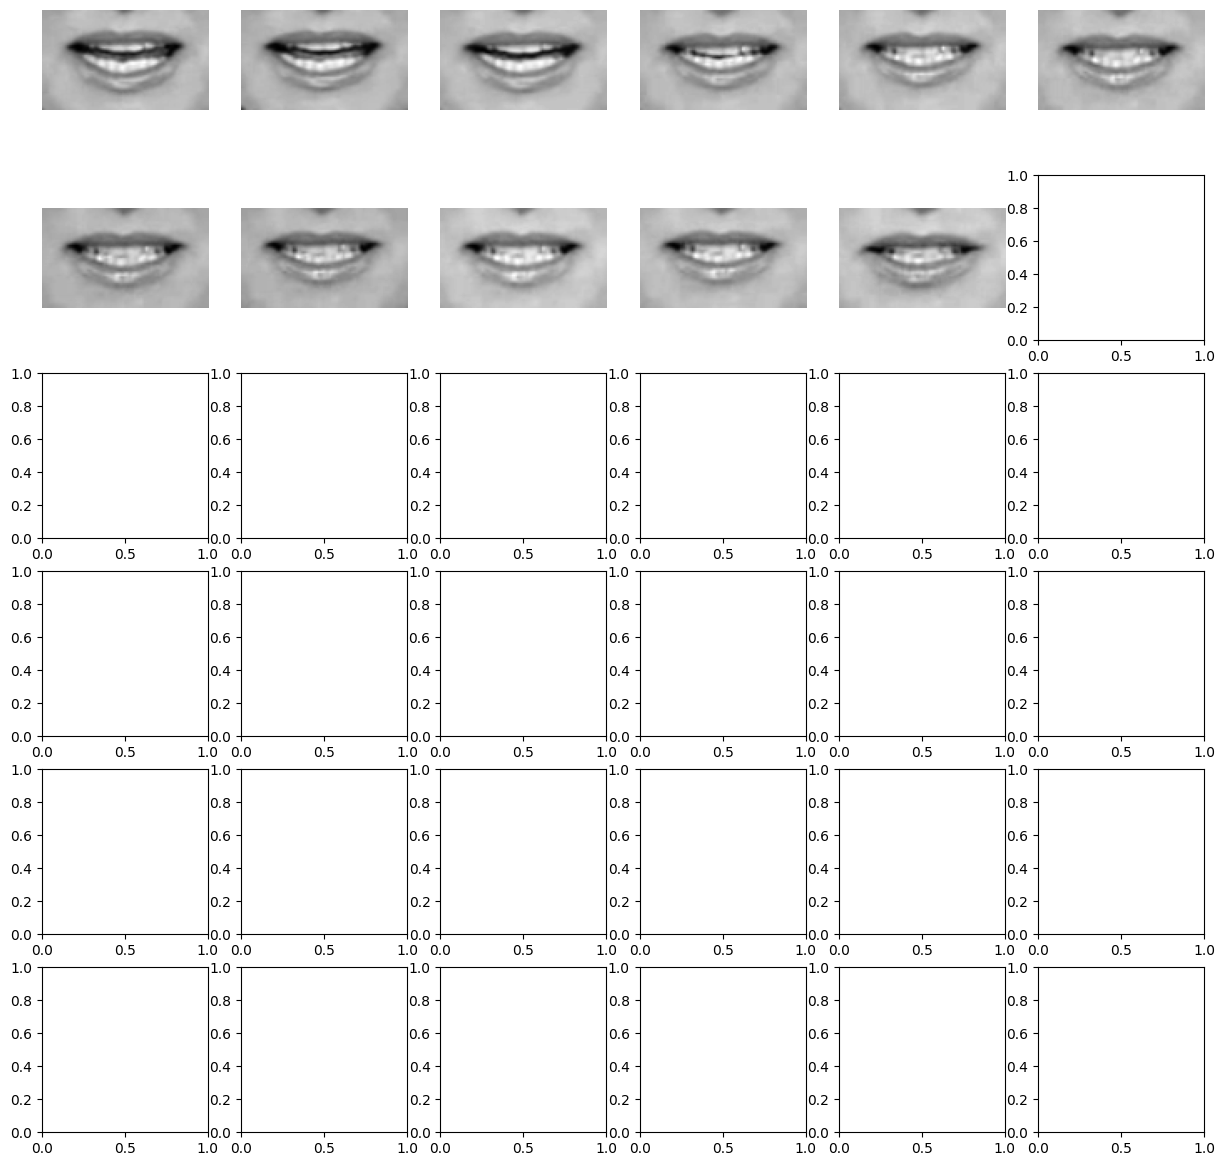

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for i in range(11):
    row = i // 6
    col = i % 6
    ax[row, col].imshow(x_train[0][i], cmap='gray')
    ax[row, col].axis('off')
plt.show()